In [1]:
import os

import torch
# import torchvision
from torchvision.transforms import v2

# from torch import nn
# from torchsummary import summary

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm

%load_ext autoreload

from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

<Figure size 500x500 with 0 Axes>

In [2]:
test_prop = 0.2
val_prop = 0.1

batch_size = 64

# img_type = 'raw-derivative.-60'
# img_type = 'raw-original'
# img_type = 'raw-fft'

In [61]:
# Creating the datasets

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.Normalize(mean=[0], std=[67]),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),

    v2.ToDtype(torch.float, scale=True),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])

target_transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0], std=[67]),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),
    v2.ToDtype(torch.float, scale=True),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])


train_labeled_data = CloudDetectionTrain(
    transform=transform
)

test_labeled_data = CloudDetectionTrain(
    target_transform=target_transform
)

pano_df = train_labeled_data.dataset_manager.main_dfs['pano']
feature_df = train_labeled_data.dataset_manager.main_dfs['feature']
feature_merged_df = feature_df.reset_index().merge(pano_df, on = 'pano_uid').set_index('index')
dsl_merged = feature_merged_df.merge(train_labeled_data.dsl_df, on = 'feature_uid').reset_index()

In [62]:
def data_split(test_prop, val_prop, batch_id, boundary_prop=0.1):
    assert 0 <= test_prop <= 1, 0 <= val_prop <= 1
    batch_data = dsl_merged[dsl_merged['batch_id_x'] == batch_id].sort_values(by = 'frame_unix_t')
    
    test_split = int(len(batch_data) * test_prop)
    ntrain = len(batch_data) - test_split
    val_split = int(ntrain * val_prop)
    boundary_cnt = int((len(batch_data) - val_split) * boundary_prop)
    
    test_idx = batch_data[:test_split].index.values
    val_idx = batch_data[test_split: test_split + val_split].index.values
    train_idx = batch_data[test_split + val_split + boundary_cnt:].index.values
    
    return test_idx, val_idx, train_idx

def get_windowed_test_val_train_indices(test_prop, val_prop):
    test_indices = np.array([], dtype=np.int64)
    val_indices = np.array([], dtype=np.int64)
    train_indices = np.array([], dtype=np.int64)

    for batch_id in pano_df['batch_id'].unique():
        test_idx, val_idx, train_idx = data_split(test_prop, val_prop, batch_id)
        test_indices = np.concatenate((test_indices, test_idx))
        val_indices = np.concatenate((val_indices, val_idx))
        train_indices = np.concatenate((train_indices, train_idx))
    return test_indices, val_indices, train_indices

def get_shuffled_test_val_train_indices(test_prop, val_prop):
    dataset_size = len(dsl_merged)
    dataset_indices = np.arange(dataset_size)
    
    np.random.shuffle(dataset_indices)
    
    # Test / Train split
    test_split_index = int(np.floor(test_prop * dataset_size))
    trainset_indices, test_idx = dataset_indices[test_split_index:], dataset_indices[:test_split_index]
    
    # Train / Val split
    trainset_size = len(trainset_indices)
    val_split_index = int(np.floor(val_prop * trainset_size))
    train_idx, val_idx = trainset_indices[val_split_index:], trainset_indices[:val_split_index]
    return test_idx, val_idx, train_idx

In [63]:
test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(test_prop, val_prop)
test_idx, val_idx, train_idx = get_shuffled_test_val_train_indices(test_prop, val_prop)
# print(test_idx, val_idx, train_idx)

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)


# Get dataset stats

print(f'test_prop = {100 * len(test_idx) / dataset_size:.2f}%\n'
      f'train_prop = {100 * len(train_idx) / dataset_size:.2f}%\n'
      f'val_prop = {100 * len(val_idx) / dataset_size:.2f}%'
)
# feature_uid = train_labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
# train_labeled_data[0][0]
def print_class_dist(data, idx, name):
    filtered_data = data.iloc[idx]
    num_clear = len(filtered_data.loc[filtered_data['label'] == 'clear_night_sky'])
    num_cloudy = len(filtered_data.loc[filtered_data['label'] == 'not_clear_cloudy'])
    print(f'Percent cloudy (in {name}) = {100 *num_cloudy / len(filtered_data):.3f}% ({num_cloudy} / {len(filtered_data)})')

print_class_dist(dsl_merged, test_idx, 'train')
print_class_dist(dsl_merged, val_idx, 'val')
print_class_dist(dsl_merged, train_idx, 'train')
print_class_dist(dsl_merged, dsl_merged.index, 'overall')

test_prop = 19.99%
train_prop = 72.01%
val_prop = 8.00%
Percent cloudy (in train) = 56.339% (991 / 1759)
Percent cloudy (in val) = 52.841% (372 / 704)
Percent cloudy (in train) = 54.940% (3481 / 6336)
Percent cloudy (in overall) = 55.052% (4844 / 8799)


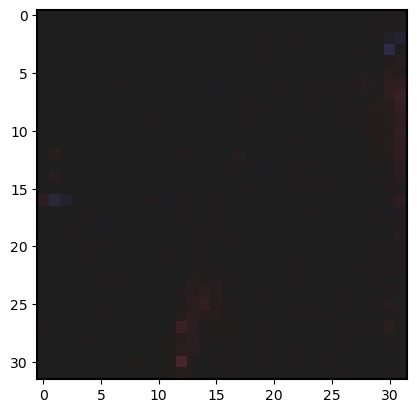

In [6]:
rn = np.random.choice(len(train_labeled_data), size=30, replace=False)
train_labeled_data.dataset_manager.main_dfs['feature']['batch_id'].unique()
images = [train_labeled_data[i][0][0] for i in rn]
# plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=10, padding=5).numpy().transpose((1, 2, 0)));
import time
from IPython import display

try:
    for j in range(len(train_labeled_data)):
        images = [train_labeled_data[i][0][0] for i in rn]
        for i in images:
            # plt.figure(figsize=(20,10))
            plt.imshow(i, vmin=-2, vmax=2, cmap='icefire')
            plt.show()
            plt.close()
            time.sleep(.01)
            display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()

In [24]:
# Code for finding the intersection between two arrays
arr1 = np.array(
    [[1,2,3,4,5],
     [1,2,3,4,5],
     [1,2,3,4,5]
    ]
)
arr2 = np.array(
    [[1,2,3,40,50],
    [1,2,3,40,50],
    [1,2,3,40,50]]
)
np.stack((arr1, arr2)).shape

(2, 3, 5)

In [7]:
# Use that code here:
test = set(test_idx)
train = set(train_idx)
val = set(val_idx)
print(test.intersection(train))  # empty set, showing there is no overlap between test and train indices.
print(test.intersection(val))    # empty set, showing there is no overlap between test and val indices.

set()
set()


In [168]:
# Training config

learning_rate = 0.001
# momentum=0.9

model = CloudDetection()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=40, gamma=0.9, do_summary=True,
    # img_type=img_type
);

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 24, 32, 32]          240
|    └─ReLU: 2-2                         [-1, 24, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 24, 32, 32]          48
|    └─Dropout2d: 2-4                    [-1, 24, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 24, 32, 32]          5,208
|    └─ReLU: 2-6                         [-1, 24, 32, 32]          --
|    └─BatchNorm2d: 2-7                  [-1, 24, 32, 32]          48
|    └─Dropout2d: 2-8                    [-1, 24, 32, 32]          --
|    └─MaxPool2d: 2-9                    [-1, 24, 10, 10]          --
├─Sequential: 1-2                        [-1, 48, 3, 3]            --
|    └─Conv2d: 2-10                      [-1, 48, 10, 10]          10,416
|    └─ReLU: 2-11                        [-1, 48, 10, 10]          --
|    └─

In [169]:
trainer.train()



Epoch 1


  0%|          | 0/99 [00:00<?, ?batches/s]

       Val: 	loss = 0.5436,  acc = 590/704 (83.81%) 



Epoch 2


  0%|          | 0/99 [00:00<?, ?batches/s]

       Val: 	loss = 0.4800,  acc = 608/704 (86.36%) 



Epoch 3


  0%|          | 0/99 [00:00<?, ?batches/s]

       Val: 	loss = 0.4531,  acc = 641/704 (91.05%) 



Epoch 4


  0%|          | 0/99 [00:00<?, ?batches/s]

       Val: 	loss = 0.4275,  acc = 639/704 (90.77%) 



Epoch 5


  0%|          | 0/99 [00:00<?, ?batches/s]

Keyboard Interrupt: Stopping training


  0%|          | 0/28 [00:00<?, ?batches/s]

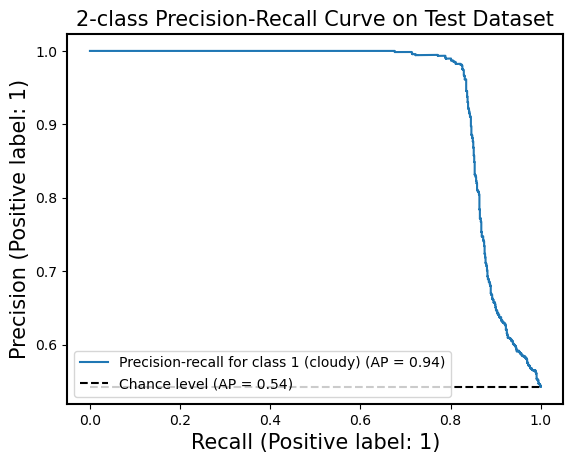

Test: 	loss = 0.4107,  acc = 1640/1759 (93.23%)


In [170]:
tester = Tester(model, loss_fn, test_loader)
tester.eval()

  0%|          | 0/28 [00:00<?, ?batches/s]

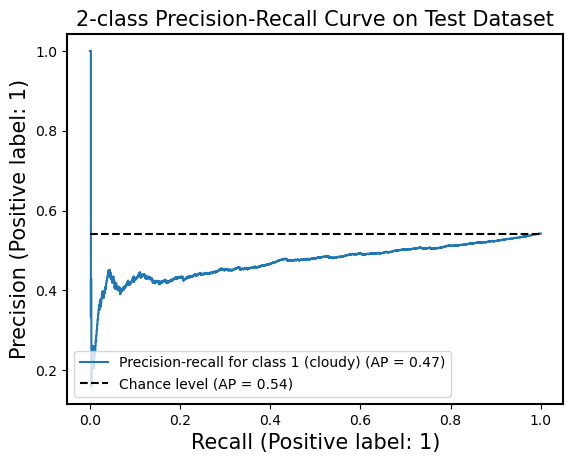

Test: 	loss = 0.3439,  acc = 1708/1759 (97.10%)


In [105]:
model.load_state_dict(torch.load('../model_training/best_cloud_detection_model.pth'))
tester = Tester(model, loss_fn, test_loader)
tester.eval()